# LangChain Basics with OpenAI

This notebook introduces the fundamentals of LangChain, a powerful framework for building applications with Large Language Models (LLMs). We'll cover:
- Basic LangChain setup with OpenAI
- Message types (SystemMessage, HumanMessage)
- Prompt templates and chaining with LCEL
- Streaming responses
- Multimodal capabilities (text + images)

In [4]:
from langchain_openai import ChatOpenAI
from src.fnUtils import stream_markdown, render_markdown

## Setup: Initialize the LLM

Here we import message classes from LangChain and create a ChatOpenAI model instance. The model will use OpenAI's GPT-4o-mini by default.

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
model_name = 'gpt-4o-mini'
# Other options: "gpt-4o", 'gpt-4-turbo'
model = ChatOpenAI(model=model_name)

## Example 1: Simple Classification with System and Human Messages

This function demonstrates how to use `SystemMessage` (for setting context/role) and `HumanMessage` (for user input) to create a simple fruit classifier.

In [6]:
def classify_produce(given_item = "apple"):
    msgs =[
            SystemMessage(content="You are fruit identifier."),
            HumanMessage(content=f"You MUST limit your answer to Yes/No. Is {given_item} a fruit?"),
    ]
    response = model.invoke(msgs)
    return response.content

print(classify_produce())

Yes.


### Test with a Different Item

Test the classifier with "cucumber" - is it a fruit? The LLM will decide based on its training.

In [7]:
item = "cucumber"
print(classify_produce(item))

Yes.


## Example 2: Creative Text Generation

Create an LLM instance with temperature=0.5 for balanced creativity. The LLM generates a paragraph about prompt engineering, which we render as formatted markdown.

In [8]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.5)

# Send a creative prompt to the LLM
prompt = 'Write a short paragraph about the importance of prompt engineering.'
response = llm.invoke(prompt)
render_markdown(response.content)

> Prompt engineering is crucial in the realm of artificial intelligence and natural language processing, as it directly influences the quality and relevance of the outputs generated by AI models. By carefully crafting prompts, users can guide the AI to produce more accurate, contextually appropriate, and coherent responses. This practice not only enhances user experience but also optimizes the model's potential, enabling it to better understand and fulfill specific tasks. As AI systems become increasingly integrated into various applications, mastering prompt engineering will be essential for harnessing their capabilities effectively and ensuring that they align with user intentions and expectations.

## Example 3: Self-Evaluation Pattern

This demonstrates a powerful pattern: using an LLM to evaluate another LLM's output. We pass both the original question and answer to a second LLM acting as an evaluator.

In [23]:
llm1 = ChatOpenAI(model='gpt-4o-mini', temperature=0.5)

# Build an evaluation prompt that includes the original question and answer
evaluation_prompt = f"""
Question: {prompt}

Answer: {response.content}

Look at the question and evaluate the answer.
Check for accuracy and relevance.
Target audience for the answer is analytics professionals.
"""

messages = [
    SystemMessage(content="You are an evaluator of questions and answers."),
    HumanMessage(content=evaluation_prompt),
]

response1 = llm1.invoke(messages)
render_markdown(response1.content)

> The answer provided does not address the question posed. The question asks for a comprehensive chapter on the mathematical foundation of our universe, which suggests a focus on topics such as the role of mathematics in physics, the laws of nature, mathematical models, and possibly the philosophical implications of these mathematical structures.
> 
> Instead, the response discusses prompt engineering in the context of artificial intelligence and natural language processing, which is entirely unrelated to the question about the mathematical foundation of the universe. 
> 
> **Evaluation:**
> 
> 1. **Accuracy:** The answer is inaccurate as it does not pertain to the subject matter of the question. It fails to provide any information about mathematics in relation to the universe.
> 
> 2. **Relevance:** The content is irrelevant to the topic of the mathematical foundation of our universe. It discusses AI and prompt engineering, which have no connection to the philosophical or scientific exploration of the universe's mathematical underpinnings.
> 
> 3. **Target Audience:** The target audience for the answer is analytics professionals; however, even for that audience, the response does not provide useful information. Analytics professionals would benefit from insights into how mathematical models apply to understanding the universe, rather than a discussion on AI prompt engineering.
> 
> In summary, the answer does not meet the requirements of the question and fails to provide any relevant or accurate information. A comprehensive, complete, and defensible chapter on the mathematical foundation of our universe would need to explore concepts such as the role of mathematics in formulating physical laws, the significance of mathematical structures in theoretical physics, and the philosophical implications of these mathematical frameworks.

## Example 4: Prompt Templates and LCEL Chains

`PromptTemplate` allows you to create reusable prompts with placeholders. The LCEL pipe operator (`|`) chains the template with the LLM, creating a composable workflow.

In [18]:
from langchain_core.prompts import PromptTemplate

# Set up a prompt template with a placeholder for input
prompt_template = PromptTemplate.from_template('You are a content creator. Write me a tweet about {input}')

# Create a chain using the LCEL pipe operator (|)
# This chains the prompt template with the LLM
chain = prompt_template | llm1

# Invoke the chain with a topic
topic = 'Why AI will change the world.'
response = chain.invoke(input=topic)
render_markdown(response.content)

> 🌍✨ AI is set to revolutionize our world by enhancing productivity, unlocking new discoveries, and personalizing experiences like never before! From healthcare to education, its potential is limitless. Let's embrace the future and harness AI for good! 🤖💡 #AI #FutureOfWork #Innovation

## Example 5: Few-Shot Learning with Output Language Control

This example shows few-shot learning (providing an example) and controlling the output language. The LLM responds in Spanish because we explicitly requested it.

In [20]:
this_animal = 'whale'
output = llm1.invoke([
    SystemMessage(content='You are an animal classifier.'),
    HumanMessage(content="Example: Tiger is a Mammal."),
    HumanMessage(content=f'Answer only YES or NO in Spanish. Is {this_animal} a mammal?')
])
print(output.content)

SÍ


## Example 6: Streaming Responses

For long-form content, streaming allows you to see responses as they're generated (token by token) rather than waiting for completion. We accumulate chunks into `full_response` for later use.

In [36]:
# Send a prompt requiring detailed, continuous output
print(llm.model_name)
# Define a sophisticated prompt for long-form chapter writing
prompt = """You are a Philosophy of Science researcher passionate about scientific realism and the development of scientific theories.
You engage thoughtfully with complex questions, often thinking through problems aloud.

Your task: Write a foundational chapter for a book titled 'The Nature of Our Universe' examining the mathematical foundations of our universe from a philosophical perspective.

Consider fundamental questions about the relationship between mathematics and physical reality, the nature of mathematical truth, and why mathematical structures appear so central to our scientific understanding. 

Engage with multiple philosophical perspectives, acknowledge genuine controversies, and build your argument systematically. Think through the implications as you write.
"""

# Stream the response and collect chunks
chapter_response = ""
for chunk in llm.stream(prompt):
    print(chunk.content, end='', flush=True)
    chapter_response += chunk.content

# full_response now contains the complete text for later use

gpt-4o
# Chapter 1: The Mathematical Nexus and the Tapestry of Reality

## Introduction

In contemplating the grand tapestry of our universe, one cannot help but marvel at the intricate structures that govern its very existence. At the heart of this wonder lies a profound question: Why is mathematics so deeply embedded in the fabric of our universe, and what does this imply about its nature? This chapter embarks on a journey through the philosophical landscapes that interrogate the mathematical underpinnings of our universe. By examining fundamental questions about the relationship between mathematics and physical reality, the nature of mathematical truths, and the centrality of mathematical structures in scientific understanding, we hope to paint a more comprehensive picture of this enigmatic subject.

## The Enigma of Mathematical Structures

The notion that mathematics provides a foundational framework for understanding the universe is not a radical concept, but rather one that has 

### Display the Complete Streamed Response

Now we can render the complete response as formatted markdown after it was streamed.

In [38]:
render_markdown(chapter_response)

> # Chapter 1: The Mathematical Nexus and the Tapestry of Reality
> 
> ## Introduction
> 
> In contemplating the grand tapestry of our universe, one cannot help but marvel at the intricate structures that govern its very existence. At the heart of this wonder lies a profound question: Why is mathematics so deeply embedded in the fabric of our universe, and what does this imply about its nature? This chapter embarks on a journey through the philosophical landscapes that interrogate the mathematical underpinnings of our universe. By examining fundamental questions about the relationship between mathematics and physical reality, the nature of mathematical truths, and the centrality of mathematical structures in scientific understanding, we hope to paint a more comprehensive picture of this enigmatic subject.
> 
> ## The Enigma of Mathematical Structures
> 
> The notion that mathematics provides a foundational framework for understanding the universe is not a radical concept, but rather one that has been accepted for centuries. From the early Pythagoreans, who saw numbers as the essence of all things, to the modern physicists who utilize complex equations to unravel the mysteries of quantum mechanics and general relativity, mathematics appears as an indispensable language of the cosmos.
> 
> ### The Efficacy of Mathematics
> 
> One of the most striking phenomena is what physicist Eugene Wigner famously referred to as "the unreasonable effectiveness of mathematics." How is it that abstract mathematical entities, conceived in the human mind, map so seamlessly onto the physical world? This question has spurred numerous philosophical debates, invoking perspectives ranging from Platonism to formalism.
> 
> #### Platonism and Mathematical Realism
> 
> Platonism posits that mathematical entities exist in an abstract realm, independent of human thought and the physical universe. Under this view, mathematical truths are discovered, not invented, with the physical universe simply reflecting these pre-existing structures. The appeal of Platonism lies in its ability to account for the seemingly objective nature of mathematical truths, as well as the precision with which mathematics describes physical phenomena.
> 
> Yet, Platonism raises its own conundrums. If mathematical entities exist in a non-physical realm, how do they interact with the physical universe? Moreover, why should our universe, in particular, be so amenable to mathematical description?
> 
> #### Formalism, Conventionalism, and Constructivism
> 
> Contrasting sharply with Platonism are formalism and conventionalism, which argue that mathematics is a construct of human invention, a set of symbolic systems governed by rules. According to formalists, mathematics serves as a toolkit we apply to model the universe rather than a description of an underlying reality. Through this lens, the efficacy of mathematics is a result of our careful construction of models that fit within the constraints of our scientific observation.
> 
> Constructivism, while sharing some ground with formalism, insists that mathematical objects only exist insofar as they are constructible within a human framework. This perspective aligns with intuitionism, which emphasizes mathematics as a mental construct emerging from human intuition and cognitive processes.
> 
> #### A Middle Ground?
> 
> Amidst these debates, some philosophers propose a more middle-ground view: mathematical structures are indeed reflective of the informational or relational properties of the universe itself. In this emergentist perspective, mathematical truths do not exist independently of the physical universe but are inherently tied to its functioning.
> 
> ## The Nature of Mathematical Truth
> 
> Examining the nature of mathematical truth propels us into a deeper philosophical inquiry: Is mathematics universally true, and if so, why? Mathematical truth holds a unique place in the sciences due to its abstraction, consistency, and apparent universality.
> 
> ### Consistency and Incompleteness
> 
> Kurt Gödel's incompleteness theorems famously revealed limitations within formal mathematical systems, suggesting that not all mathematical truths can be proven within a given system. This presents a formidable challenge: Could these intrinsic limitations in formal mathematics suggest that our mathematical understanding of the universe is ultimately incomplete?
> 
> ### Universality and Objectivity
> 
> The universality of mathematics is often seen as evidence of its objective status. However, this raises further questions. If mathematics is objectively true, does this imply that its truths exist in all possible worlds, independent of their physical realization? Could alternative mathematical structures govern other conceivable universes, and if so, what prompts the structures of our specific universe?
> 
> ## Implications: Mathematics as a Fundamental Descriptor?
> 
> The centrality of mathematical structures within scientific theories cannot be understated. Mathematics has become a critical tool, not only allowing us to describe existing phenomena but also to predict, discover, and imagine aspects of the universe heretofore unknown. Quantum mechanics, with its intricate mathematical formulations, provides just one compelling example of how mathematics pushes the boundaries of human knowledge.
> 
> ### Mathematical Structures and Scientific Realism
> 
> Incorporating mathematical notions into scientific realism offers a perspective where our best scientific theories are both approximately true and, crucially, reflect an underlying mathematical reality. This interplay raises the question: If our scientific theories describe truth, to what extent is their mathematical component a reflection of reality itself?
> 
> ### Conclusion: Toward an Understanding
> 
> Concluding this chapter, the entanglement of mathematics and reality remains a tantalizing mystery with significant implications across various domains of philosophy and science. While the debate over the nature of mathematical truths continues, one thing remains clear: mathematics, in its elegance and precision, offers a unique lens through which we discern the universe's deepest secrets. Whether as a divine language, a human invention, or an emergent property of the universe, the mathematical foundations of reality beckon our exploration and understanding, guiding us toward a richer appreciation of our cosmos. As we continue to unravel these mysteries, we traverse an ever-fascinating confluence of logic, imagination, and reality.

## Example 7: Multimodal - Vision API

Modern LLMs like GPT-4o can process both text and images. First, we set up an image URL from Saint Joseph's University.

In [10]:
img_url = "https://www.sju.edu/news/sites/newsroom/files/styles/16_9_1600x900/public/2024-05/Ryan-Cesarini-sju-mbb_3200x1800.jpg?h=0fb54712&itok=XexLTQ2F"
#"https://www.sju.edu/news/sites/newsroom/files/styles/16_9_1600x900/public/2024-06/bonnie-yu-lacrosse_3200x1800.jpg?h=f0fb51a5&itok=1ZLMRAtS"

### Display the Image

Use IPython's Image display to preview the image we'll analyze.

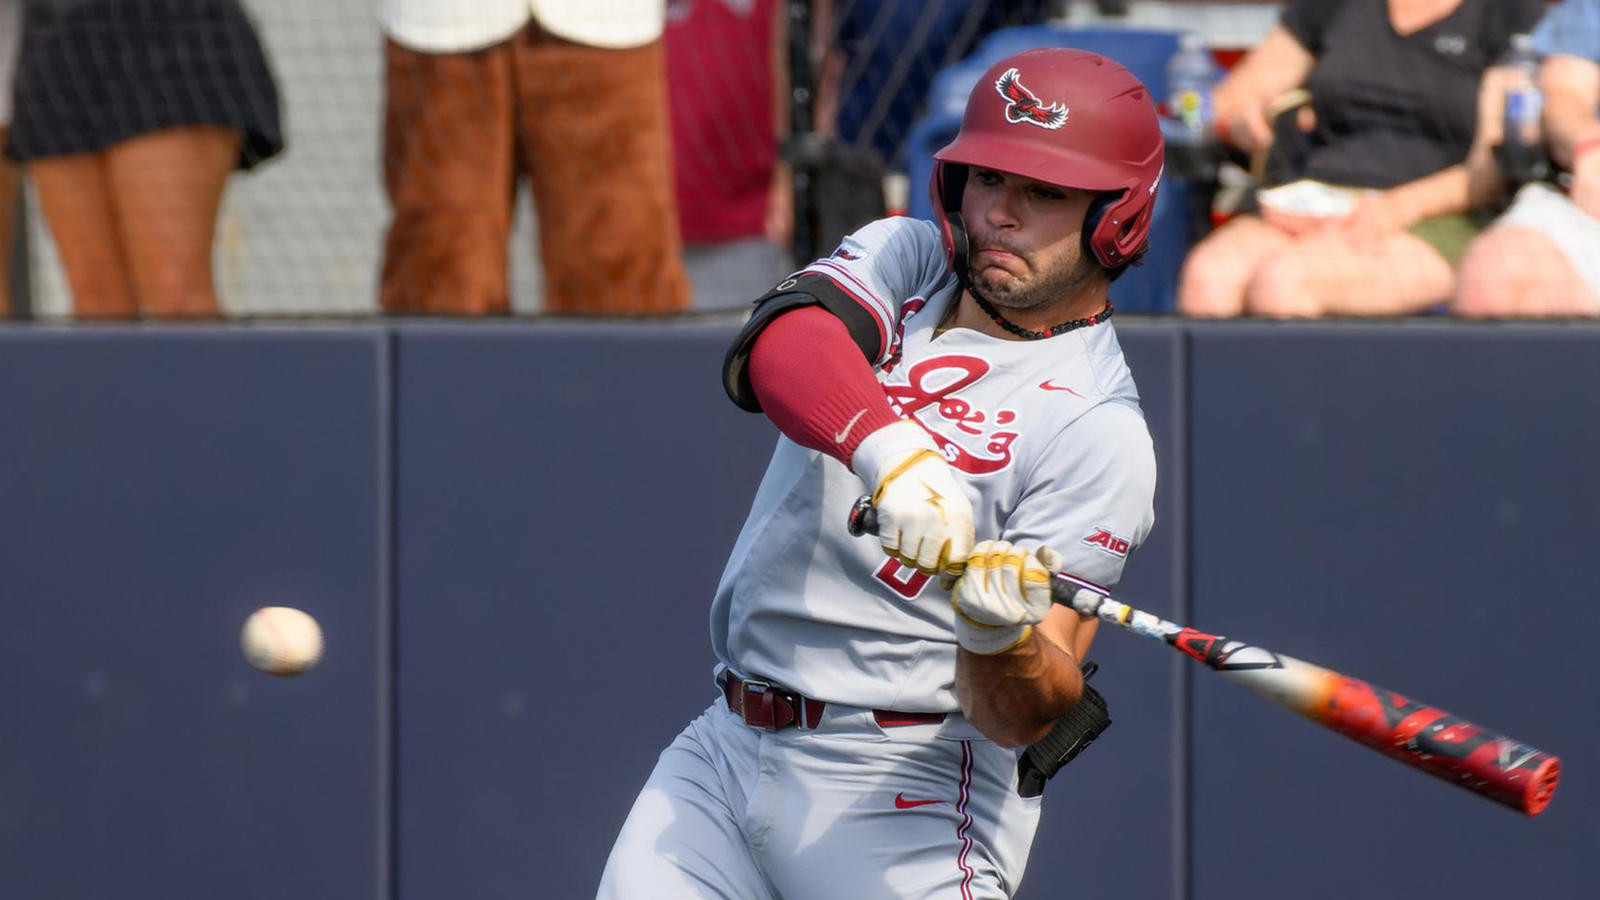

In [28]:
import requests
from IPython.display import Image

# image_url = "https://picsum.photos/seed/picsum/300/300"
content = requests.get(img_url).content
Image(content)

### Analyze the Image with GPT-4o

Create a multimodal message with both text and image. The `content` is a list containing:
- A text part with our question
- An image_url part with the URL wrapped in `{"url": "..."}` format

In [15]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

# Create a multimodal message with text and image
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "What's in this image?",
        },
        {
            "type": "image_url",
            "image_url": {"url": img_url}
        },
    ]
)
msg = llm.invoke([message])

render_markdown(msg.content)

> The image shows a baseball player in action during a game. The player is wearing a helmet and uniform, holding a bat, and appears to be in the process of hitting or about to hit a baseball. There's a crowd in the background, likely spectators watching the game.

### Ask a More Specific Question

Now we ask the model to identify logos in the image, demonstrating the vision model's ability to detect and recognize specific elements.

In [33]:
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "What's in this image? Can you identify any logos in this image?"
        },
        {
            "type": "image_url",
            "image_url": {"url": img_url}
        },
    ]
)
msg = llm.invoke([message])
render_markdown(msg.content)

The image shows a baseball player in action, swinging a bat. The player's helmet has an unidentified logo that looks like a bird, and there is a recognizable logo on the jersey sleeve. The jersey also has writing, "Joe's" prominently displayed. The background indicates an outdoor baseball field with a few spectators.


### Verify Model and Repeat Analysis

Check which model we're using and perform another image analysis to demonstrate consistency.

In [16]:
print(llm.model_name)
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "What's in this image? Can you identify any logos in this image?"
        },
        {
            "type": "image_url",
            "image_url": {"url": img_url}
        },
    ]
)
msg = llm.invoke([message])
render_markdown(msg.content)

gpt-4o


> The image shows a baseball player in action, swinging a bat. The player is wearing a helmet and jersey with visible logos. The helmet has a logo of a bird, and there are Nike swooshes on the sleeve and jersey. He is also wearing batting gloves and has protective gear on his arm. The background includes spectators sitting behind a fence.

## LCEL Chain-Based Study Guide (Sequential Pipeline)

This section demonstrates LangChain Expression Language (LCEL) chaining. We:
- Define prompt templates for each stage.
- Compose a sequential chain using the `|` pipe operator.
- Pass the streamed chapter text (`chapter_response` from Cell 18) through the chain.

Outcome: A single, compiled study guide including Outline, Key Concepts, and Practice Questions.

In [39]:
# LCEL chain: Outline -> Concepts -> Questions -> Final Guide
# Requires: chapter_response (from Cell 18) and llm1 (ChatOpenAI)

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

### Define the Outline Chain
We start by turning the raw chapter text into a structured outline (numbered sections and subsections).

In [40]:
# 1) Outline prompt + chain
outline_prompt_t = PromptTemplate.from_template(
    """
You are a meticulous technical editor.
Create a structured outline from the chapter text.
- Use numbered sections and nested subsections (e.g., 1., 1.1., 1.1.1.)
- Keep headings concise
- Preserve the logical flow

Chapter Text:
{chapter_text}
"""
)

# Chain to produce outline from raw chapter text input
outline_chain = {"chapter_text": RunnablePassthrough()} | outline_prompt_t | llm1 | StrOutputParser()

### Define the Concepts Chain
Use both the outline and chapter text to extract 10–15 key concepts (term — one-sentence definition).

In [41]:
# 2) Concepts prompt + chain
concepts_prompt_t = PromptTemplate.from_template(
    """
You are a subject matter expert and glossary builder.
Extract 10-15 key concepts based on the chapter text and outline.
Return a bullet list where each item is:
Term — One-sentence definition.

Outline:
{outline}

Chapter Text:
{chapter_text}
"""
)

concepts_chain = {
    "chapter_text": RunnablePassthrough(),
    "outline": outline_chain,
} | concepts_prompt_t | llm1 | StrOutputParser()

### Define the Questions Chain
Generate 6–8 practice questions with detailed answers and a difficulty label using the concepts + chapter text.

In [42]:
# 3) Questions prompt + chain
questions_prompt_t = PromptTemplate.from_template(
    """
You are a learning designer creating practice questions.
Use the chapter text and extracted concepts to generate 6–8 items.
For each item, include:
- Question
- Detailed Answer (2-4 sentences)
- Difficulty: Beginner | Intermediate | Advanced
Return markdown with clear headings per item.

Key Concepts:
{key_concepts}

Chapter Text:
{chapter_text}
"""
)

questions_chain = {
    "chapter_text": RunnablePassthrough(),
    "key_concepts": concepts_chain,
} | questions_prompt_t | llm1 | StrOutputParser()

### Compile and Render Final Study Guide
We combine all prior outputs (outline, concepts, questions) into a single, readable study guide and render it.

In [43]:
# 4) Final formatter + chain + invoke
final_guide_prompt_t = PromptTemplate.from_template(
    """
# Study Guide

## Table of Contents
1. Outline
2. Key Concepts
3. Practice Questions

## Outline
{outline}

## Key Concepts
{key_concepts}

## Practice Questions
{study_questions}
"""
)

final_guide_chain = {
    "outline": outline_chain,
    "key_concepts": concepts_chain,
    "study_questions": questions_chain,
} | final_guide_prompt_t | llm1 | StrOutputParser()

# Invoke the chain with the streamed chapter text
compiled_study_guide = final_guide_chain.invoke(chapter_response)
render_markdown(compiled_study_guide)

> # Study Guide
> 
> ## Table of Contents
> 1. Outline
> 2. Key Concepts
> 3. Practice Questions
> 
> ## Outline
> # Outline of Chapter 1: The Mathematical Nexus and the Tapestry of Reality
> 
> ## 1. Introduction
> 1.1. Overview of the chapter's theme  
> 1.2. Central questions regarding mathematics and the universe  
> 1.3. Purpose of the chapter  
> 
> ## 2. The Enigma of Mathematical Structures
> 2.1. Historical perspective  
> 2.1.1. Pythagorean views on numbers  
> 2.1.2. Modern physics and complex equations  
> 2.2. The role of mathematics in understanding the cosmos  
> 
> ### 2.3. The Efficacy of Mathematics
> 2.3.1. Wigner's concept of "unreasonable effectiveness"  
> 2.3.2. Philosophical implications  
> 2.3.2.1. Platonism  
> 2.3.2.2. Formalism  
> 2.3.2.3. Conventionalism  
> 2.3.2.4. Constructivism  
> 
> #### 2.3.3. A Middle Ground?
> 2.3.3.1. Emergentist perspective  
> 2.3.3.2. Relationship between mathematical truths and the physical universe  
> 
> ## 3. The Nature of Mathematical Truth
> 3.1. Philosophical inquiries into mathematical truth  
> 3.2. Characteristics of mathematical truth  
> 3.2.1. Abstraction  
> 3.2.2. Consistency  
> 3.2.3. Universality  
> 
> ### 3.3. Consistency and Incompleteness
> 3.3.1. Gödel's incompleteness theorems  
> 3.3.2. Implications for understanding mathematical completeness  
> 
> ### 3.4. Universality and Objectivity
> 3.4.1. Objective status of mathematics  
> 3.4.2. Existence of mathematical truths across possible worlds  
> 3.4.3. Alternative mathematical structures in different universes  
> 
> ## 4. Implications: Mathematics as a Fundamental Descriptor
> 4.1. Centrality of mathematics in scientific theories  
> 4.2. Role of mathematics in discovery and prediction  
> 4.3. Case study: Quantum mechanics  
> 
> ### 4.4. Mathematical Structures and Scientific Realism
> 4.4.1. Relationship between scientific theories and mathematical reality  
> 4.4.2. Questions regarding the reflection of reality in mathematical components  
> 
> ## 5. Conclusion: Toward an Understanding
> 5.1. Summary of key themes  
> 5.2. Ongoing debates about mathematical truths  
> 5.3. Mathematics as a lens for understanding the universe  
> 5.4. Call for further exploration and appreciation of mathematics in reality  
> 
> ## Key Concepts
> - **Mathematics** — A systematic framework of concepts and principles used to describe and understand quantitative relationships and structures in the universe.
> 
> - **Philosophical Inquiry** — The exploration of fundamental questions regarding the nature and implications of mathematics and its relationship to reality.
> 
> - **Eugene Wigner's "Unreasonable Effectiveness"** — The observation that abstract mathematical concepts often find unexpected applicability in describing physical phenomena.
> 
> - **Platonism** — A philosophical view that posits mathematical entities exist independently in an abstract realm, suggesting that mathematical truths are discovered rather than invented.
> 
> - **Mathematical Realism** — A belief in the objective existence of mathematical truths that are not contingent upon human thought or perception.
> 
> - **Formalism** — The perspective that mathematics is a creation of human invention, consisting of symbols and rules used to model and describe the universe.
> 
> - **Conventionalism** — The view that mathematical truths are based on social conventions and agreements rather than objective realities.
> 
> - **Constructivism** — A philosophy asserting that mathematical objects and truths only exist when they can be constructed or demonstrated within a human framework.
> 
> - **Emergentism** — A perspective suggesting that mathematical structures arise from the informational or relational properties of the physical universe, rather than existing independently.
> 
> - **Gödel's Incompleteness Theorems** — Theorems demonstrating that within any consistent formal mathematical system, there are true statements that cannot be proven within that system, highlighting limitations in mathematical understanding.
> 
> - **Universality of Mathematics** — The idea that mathematical truths hold across various contexts and might exist independently of the physical universe, raising questions about their applicability in alternative realities.
> 
> - **Scientific Realism** — The belief that scientific theories, which often incorporate mathematical structures, accurately describe the underlying reality of the universe.
> 
> - **Mathematical Structures** — Frameworks and systems of relationships and entities in mathematics that are used to model and understand scientific theories and phenomena.
> 
> - **Physical Reality** — The tangible universe and its phenomena, which mathematics seeks to describe and explain through various theoretical frameworks.
> 
> - **Interplay of Mathematics and Science** — The relationship between mathematical formulations and scientific theories, highlighting how mathematics aids in the prediction and discovery of new phenomena.
> 
> ## Practice Questions
> # Practice Questions on Mathematics and Its Philosophical Implications
> 
> ## Question 1: What is the significance of Eugene Wigner's phrase "the unreasonable effectiveness of mathematics" in the context of mathematics and physics?
> **Answer:** Wigner's phrase highlights the remarkable ability of abstract mathematical concepts to accurately describe physical phenomena, raising questions about the relationship between mathematics and the physical universe. This observation has led to philosophical inquiries into whether mathematical truths are discovered or invented, and how they relate to the reality we observe. The effectiveness of mathematics in physics prompts discussions about the nature of mathematical entities and their ontological status.  
> **Difficulty:** Intermediate
> 
> ---
> 
> ## Question 2: How does Platonism differ from Formalism in the philosophy of mathematics?
> **Answer:** Platonism posits that mathematical entities exist independently in an abstract realm, suggesting that mathematical truths are discovered rather than invented. In contrast, Formalism views mathematics as a human-constructed system of symbols and rules, emphasizing that it serves as a tool for modeling rather than a description of underlying reality. This fundamental difference reflects contrasting beliefs about the ontological status of mathematical objects and their relationship to the physical world.  
> **Difficulty:** Intermediate
> 
> ---
> 
> ## Question 3: Explain Gödel's Incompleteness Theorems and their implications for mathematical understanding.
> **Answer:** Gödel's Incompleteness Theorems demonstrate that in any consistent formal mathematical system, there exist true statements that cannot be proven within that system. This revelation implies that our understanding of mathematics is inherently limited; some mathematical truths lie beyond the reach of formal proof. Consequently, these limitations challenge the notion of completeness in mathematics and suggest that our mathematical framework may be insufficient to fully capture the complexities of reality.  
> **Difficulty:** Advanced
> 
> ---
> 
> ## Question 4: What is the emergentist perspective on mathematical structures, and how does it differ from Platonism?
> **Answer:** The emergentist perspective posits that mathematical structures arise from the informational or relational properties of the universe, rather than existing independently in an abstract realm as suggested by Platonism. This view implies that mathematical truths are inherently tied to the physical universe's functioning and do not exist in isolation. Consequently, emergentism offers a more integrated understanding of the relationship between mathematics and reality, contrasting with Platonism's assertion of an independent mathematical realm.  
> **Difficulty:** Advanced
> 
> ---
> 
> ## Question 5: Describe the concept of Mathematical Realism and its implications for the nature of mathematical truths.
> **Answer:** Mathematical Realism is the belief that mathematical objects and truths exist objectively, similar to physical entities. This perspective asserts that mathematical truths are not merely human inventions or conventions but are instead part of the fabric of reality itself. The implications of Mathematical Realism suggest that mathematical truths are universally applicable and exist independently of human thought, raising questions about their existence across different possible worlds and their role in understanding the universe.  
> **Difficulty:** Intermediate
> 
> ---
> 
> ## Question 6: How does Conventionalism challenge the notion of mathematical truths as objective?
> **Answer:** Conventionalism argues that mathematical truths are based on social agreements and conventions rather than inherent properties of the universe. This perspective challenges the idea that mathematical truths are objective and universally valid, suggesting instead that they are contingent upon human consensus and cultural context. By emphasizing the role of social constructs in mathematics, Conventionalism raises important questions about the nature of mathematical knowledge and its applicability across different societies and contexts.  
> **Difficulty:** Intermediate
> 
> ---
> 
> ## Question 7: What role does mathematics play in the formulation of scientific theories, according to the chapter?
> **Answer:** Mathematics serves as a critical tool in formulating scientific theories, enabling scientists to describe existing phenomena, make predictions, and explore new aspects of the universe. The centrality of mathematical structures within scientific theories enhances our understanding of complex systems, such as those found in quantum mechanics. This interplay between mathematics and science underscores the importance of mathematics in expanding human knowledge and providing a framework for exploring the laws governing the universe.  
> **Difficulty:** Beginner
> 
> ---
> 
> ## Question 8: Discuss how the concept of the Universality of Mathematics raises questions about its objective status.
> **Answer:** The Universality of Mathematics suggests that mathematical truths are consistent across different contexts and potentially exist in all possible worlds, leading to questions about whether these truths are objectively real or merely human constructs. If mathematical truths are indeed universally valid, this raises philosophical inquiries about their existence independent of physical realization and whether alternative mathematical structures could govern other conceivable universes. Such considerations challenge our understanding of the nature of mathematical reality and its implications for both mathematics and science.  
> **Difficulty:** Advanced

In [ ]:
# STUDENT EXERCISE: Add a Summarize Step
# Implement a new chain stage that summarizes the compiled study guide.
# 
# Template:
# 1. Define summary_prompt_t with PromptTemplate.from_template()
# 2. Create summary_chain using the pipe operator (|)
# 3. Invoke with compiled_study_guide

# YOUR CODE HERE:

# summary_prompt_t = PromptTemplate.from_template(
#     """
# [Your prompt here]
# """
# )

# summary_chain = ... | summary_prompt_t | llm1 | StrOutputParser()

# study_summary = summary_chain.invoke(compiled_study_guide)
# render_markdown(study_summary)
